### Constants ###

In [3]:
fat_without = 0.4 #proportion of people dying without treatment
t_fat_without = 0.9 #time in weeks until death without treatment
t_rec_without = 2.5 #time in weeks until recovery without treatment

fat_with = 0.35 #proportion of people dying with treatment
t_fat_with = 1 #time in weeks until death with treatment
t_rec_with = 1.56 #time in weeks until recovery with treatment
safe_b_rate =0.73 #proportion of burials that are conducted safely

### Classes ###

In [4]:
class Uncertain_Variable:
    def __init__(self, ground_truth, variable_range):
        self.ground_truth = ground_truth
        self.variable_range = variable_range  #[value, value]
        self.original_range = original_range
        self.percentage = 1.0
        
        
        
    def fuzzifier(self):
        new_width = (self.original_range[1] - self.original_range[0]) * self.percentage
        in_current_range = False
        while in_current_range == False:
            z = new_width * randint(0,1)
            new_range = [self.ground_truth - (new_width - z), self.ground_truth + z]
            if new_range[0] >= self.variable_range[0] and new_range[1] <= self_variable_range[1]:
                self.variable_range = new_range
                in_current_range = True
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()
        

### Helper functions

In [61]:
### Helper functions for the Compartmental Model ###

#change in susceptible people
def f_dsdt(susceptible, infected, deceased, beta_i, beta_d):
    return -(beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))

#change in recovered people
def f_drdt(infected, tr3r):
    return ((1-fat_without)*infected) / t_rec_without + tr3r / (t_rec_with/3)

#change in infected people
def f_didt(susceptible, infected, deceased, treated, beta_i, beta_d, ETC_cap):
    if treated < ETC_cap:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
            - ((1 - fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without
            - min(ETC_cap - treated, infected)) 
    else:
       return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
            - ((1-fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without)

#change in treated people
def f_dtr1dt(infected, tr1, treated, ETC_cap):
    if treated < ETC_cap:
        return min(ETC_cap - treated, infected) -(1-fat_with)*tr1 / (t_rec_with/3) - fat_with*tr1 / (t_fat_with/3)
    else:
        return -(1-fat_with)*tr1 / (t_rec_with/3) - fat_with*tr1/ (t_fat_with/3)

def f_dtr2f(tr1, tr2f):
    return (fat_with * tr1) / (t_fat_with/3) - tr2f / (t_fat_with/3)
    
def f_dtr3f(tr2f,tr3f):
    return tr2f / (t_fat_with/3) - tr3f / (t_fat_with/3)

def f_dtr2r(tr1, tr2r):
    return ((1-fat_with)* tr1) / (t_rec_with/3) - tr2r / (t_rec_with/3)

def f_dtr3r(tr2r, tr3r):
    return tr2r / (t_rec_with/3) - tr3r / (t_rec_with/3)
    
#change in deceased people
def f_dddt(infected, tr3f, deceased):
    return (fat_without*infected) / t_fat_without + (fat_with*tr3f) / t_fat_with - deceased * safe_b_rate 

def f_dfdt(deceased):
    return deceased * safe_b_rate

### Model Definition ###

In [62]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def calc_population(y,t, beta_i, beta_d, safe_f, ETC_cap):
    susceptible, infected, recovered, deceased, funeral, tr1, tr2r, tr2f, tr3r, tr3f = y
    treated = tr1 + tr2r + tr2f + tr3r + tr3f

    
    dsdt = f_dsdt(susceptible, infected, deceased, beta_i, beta_d)
    didt = f_didt(susceptible, infected, deceased, treated, beta_i, beta_d, ETC_cap)
    drdt = f_drdt(infected, tr3r)
    dddt = f_dddt(infected, tr3f, deceased)
    dfdt = f_dfdt(deceased)
    dtr1dt = f_dtr1dt(infected, tr1, treated, ETC_cap)
    dtr2fdt = f_dtr2f(tr1, tr2f)
    dtr3fdt = f_dtr3f(tr2f,tr3f)
    dtr2rdt = f_dtr2r(tr1, tr2r)
    dtr3rdt = f_dtr3r(tr2r, tr3r)
    
    dydt = [dsdt, didt, drdt, dddt, dfdt, dtr1dt, dtr2rdt, dtr2fdt, dtr3rdt, dtr3fdt]
    return dydt


##Need to put a loop here that basically calls population for 1 timestep, then changes ETC_cap if necessary

def ebola_model(S0 = 4300000,
                I0 = 88,
                R0 = 0,
                D0 = 0,
                F0 = 0,
                T0 = 0,
                beta_i = 0.33,
                beta_d = 0.68,
                safe_f = 0.73,
                ETC_cap = 0):
    
    time_vec = np.linspace(0,1,2)
    
    y0 = [S0, I0, R0, D0, F0, 0, 0, 0, 0, 0]
    
    S = []
    I = []
    R = []
    D = []
    F = []
    T = []
    
    for x in range (0,20):
                                                                                          
        population = odeint(calc_population, y0, t=time_vec, args=(beta_i, beta_d, safe_f, ETC_cap))
        
        #grab the states of the compartments at the end of the timestep
        y0 = population.T[:,1]
        print(population.T)
        
        #need to store the outcomes for each timestep
        S.append(y0[0])
        I.append(y0[1])
        R.append(y0[2])
        D.append(y0[3])
        F.append(y0[4])
        T.append(y0[5]+y0[6]+y0[7]+y0[8]+y0[9])
        
        if(y0[1] > 100):
            ETC_cap = 50
        
        
    return S,I,R,D,F,T

### Model Initialisation ###

In [63]:
from ema_workbench import Model, IntegerParameter, TimeSeriesOutcome

model = Model('Ebola', function=ebola_model)

model.uncertainties = [IntegerParameter('I0', 60, 100)]

model.outcomes = [TimeSeriesOutcome('S'),
                  TimeSeriesOutcome('I'),
                  TimeSeriesOutcome('R'),
                  TimeSeriesOutcome('D'),
                  TimeSeriesOutcome('F'),
                  TimeSeriesOutcome('T')]

### Running the Model ###

[[4.30000000e+06 4.29997568e+06]
 [6.10000000e+01 4.86649723e+01]
 [0.00000000e+00 1.28520897e+01]
 [0.00000000e+00 1.66655907e+01]
 [0.00000000e+00 7.13457546e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29997568e+06 4.29994652e+06]
 [4.86649723e+01 4.57905208e+01]
 [1.28520897e+01 2.40857859e+01]
 [1.66655907e+01 2.27438043e+01]
 [7.13457546e+00 2.18595029e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29994652e+06 4.29991494e+06]
 [4.57905208e+01 4.60380289e+01]
 [2.40857859e+01 3.50714582e+01]
 [2.27438043e+01 2.54044066e+01]
 [2.18595029e+01 3.95427382e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.299

 [0.00000000e+00 0.00000000e+00]]
[[4.29936660e+06 4.29930906e+06]
 [7.80336466e+01 8.11128578e+01]
 [2.17881587e+02 2.36976783e+02]
 [4.51171186e+01 4.68974636e+01]
 [3.58367302e+02 3.91948431e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29930906e+06 4.29924926e+06]
 [8.11128578e+01 8.43135453e+01]
 [2.36976783e+02 2.56825473e+02]
 [4.68974636e+01 4.87480449e+01]
 [3.91948431e+02 4.26854682e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29924926e+06 4.29918709e+06]
 [8.43135453e+01 8.76404988e+01]
 [2.56825473e+02 2.77457381e+02]
 [4.87480449e+01 5.06716324e+01]
 [4.26854682e+02 4.63138333e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

[[4.29980189e+06 4.29975515e+06]
 [6.35247399e+01 6.59620444e+01]
 [7.48927229e+01 9.04277553e+01]
 [3.65620961e+01 3.80834788e+01]
 [1.02128132e+02 1.29375327e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29975515e+06 4.29970655e+06]
 [6.59620444e+01 6.85424025e+01]
 [9.04277553e+01 1.06565806e+02]
 [3.80834788e+01 3.96118773e+01]
 [1.29375327e+02 1.57732207e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29970655e+06 4.29965602e+06]
 [6.85424025e+01 7.12398159e+01]
 [1.06565806e+02 1.23337426e+02]
 [3.96118773e+01 4.11833361e+01]
 [1.57732207e+02 1.87219305e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.299

 [0.00000000e+00 0.00000000e+00]]
[[4.29922651e+06 4.29916246e+06]
 [8.68681817e+01 9.02959127e+01]
 [2.64607575e+02 2.85864612e+02]
 [5.02250916e+01 5.22069484e+01]
 [4.39788937e+02 4.77171963e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29916246e+06 4.29909588e+06]
 [9.02959127e+01 9.38588614e+01]
 [2.85864612e+02 3.07960425e+02]
 [5.22069484e+01 5.42669878e+01]
 [4.77171963e+02 5.16030096e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29909588e+06 4.29902668e+06]
 [9.38588614e+01 9.75623590e+01]
 [3.07960425e+02 3.30928104e+02]
 [5.42669878e+01 5.64082923e+01]
 [5.16030096e+02 5.56421529e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

[[4.29896333e+06 4.29893703e+06]
 [3.10782541e+01 1.89662203e+01]
 [3.89453072e+02 4.07226448e+02]
 [3.01493680e+01 2.29767390e+01]
 [6.08169349e+02 6.27574084e+02]
 [9.43428056e+00 9.14692333e+00]
 [6.13209516e+00 6.10456662e+00]
 [3.30196948e+00 3.28016206e+00]
 [6.13189774e+00 6.12897809e+00]
 [3.30168192e+00 3.29822228e+00]]
[[4.30000000e+06 4.29997369e+06]
 [6.60000000e+01 5.26538810e+01]
 [0.00000000e+00 1.39055368e+01]
 [0.00000000e+00 1.80316185e+01]
 [0.00000000e+00 7.71937562e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29997369e+06 4.29994214e+06]
 [5.26538810e+01 4.95437969e+01]
 [1.39055368e+01 2.60600195e+01]
 [1.80316185e+01 2.46080373e+01]
 [7.71937562e+00 2.36512581e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.299

 [0.00000000e+00 0.00000000e+00]]
[[4.29996532e+06 4.29992373e+06]
 [6.94072586e+01 6.53074819e+01]
 [1.83300098e+01 3.43517823e+01]
 [2.37689282e+01 3.24377938e+01]
 [1.01755345e+01 3.11766178e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29992373e+06 4.29987869e+06]
 [6.53074819e+01 6.56603303e+01]
 [3.43517823e+01 5.00197795e+01]
 [3.24377938e+01 3.62323456e+01]
 [3.11766178e+01 5.63968757e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29987869e+06 4.29983129e+06]
 [6.56603303e+01 6.75279352e+01]
 [5.00197795e+01 6.59853571e+01]
 [3.62323456e+01 3.84799863e+01]
 [5.63968757e+01 8.37151194e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

 [0.00000000e+00 0.00000000e+00]]
[[4.29994564e+06 4.29991355e+06]
 [4.65411765e+01 4.67927380e+01]
 [2.44806327e+01 3.56463955e+01]
 [2.31166511e+01 2.58208677e+01]
 [2.22178540e+01 4.01909759e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29991355e+06 4.29987977e+06]
 [4.67927380e+01 4.81237907e+01]
 [3.56463955e+01 4.70242536e+01]
 [2.58208677e+01 2.74226954e+01]
 [4.01909759e+01 5.96592557e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29987977e+06 4.29984452e+06]
 [4.81237907e+01 4.98552419e+01]
 [4.70242536e+01 5.87767886e+01]
 [2.74226954e+01 2.86944695e+01]
 [5.96592557e+01 8.01514354e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

 [0.00000000e+00 0.00000000e+00]]
[[4.29916246e+06 4.29909588e+06]
 [9.02959127e+01 9.38588614e+01]
 [2.85864612e+02 3.07960425e+02]
 [5.22069484e+01 5.42669878e+01]
 [4.77171963e+02 5.16030096e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29909588e+06 4.29902668e+06]
 [9.38588614e+01 9.75623590e+01]
 [3.07960425e+02 3.30928104e+02]
 [5.42669878e+01 5.64082923e+01]
 [5.16030096e+02 5.56421529e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.30000000e+06 4.29997090e+06]
 [7.30000000e+01 5.82383471e+01]
 [0.00000000e+00 1.53803620e+01]
 [0.00000000e+00 1.99440563e+01]
 [0.00000000e+00 8.53809556e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

 [3.29959666e+00 3.30168192e+00]]
[[4.30000000e+06 4.29996970e+06]
 [7.60000000e+01 6.06316876e+01]
 [0.00000000e+00 1.60124297e+01]
 [0.00000000e+00 2.07636721e+01]
 [0.00000000e+00 8.88897544e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29996970e+06 4.29993337e+06]
 [6.06316876e+01 5.70503286e+01]
 [1.60124297e+01 3.00084817e+01]
 [2.07636721e+01 2.83364972e+01]
 [8.88897544e+00 2.72347651e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29993337e+06 4.29989403e+06]
 [5.70503286e+01 5.73586213e+01]
 [3.00084817e+01 4.36955021e+01]
 [2.83364972e+01 3.16513068e+01]
 [2.72347651e+01 4.92662896e+01]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

[[4.29974895e+06 4.29969912e+06]
 [6.76318959e+01 7.02775631e+01]
 [9.27170157e+01 1.09263605e+02]
 [3.90475840e+01 4.06146674e+01]
 [1.32650593e+02 1.61725341e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29969912e+06 4.29964731e+06]
 [7.02775631e+01 7.30432473e+01]
 [1.09263605e+02 1.26459799e+02]
 [4.06146674e+01 4.22259003e+01]
 [1.61725341e+02 1.91958914e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29964731e+06 4.29959346e+06]
 [7.30432473e+01 7.59231303e+01]
 [1.26459799e+02 1.44333483e+02]
 [4.22259003e+01 4.38949512e+01]
 [1.91958914e+02 2.23389277e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.299

[[4.29919392e+06 4.29912415e+06]
 [9.46299001e+01 9.83638125e+01]
 [2.76470329e+02 2.99626683e+02]
 [5.47127894e+01 5.68716803e+01]
 [4.57269301e+02 4.97992547e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29912415e+06 4.29905162e+06]
 [9.83638125e+01 1.02245014e+02]
 [2.99626683e+02 3.23696736e+02]
 [5.68716803e+01 5.91157334e+01]
 [4.97992547e+02 5.40322667e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29905162e+06 4.29898329e+06]
 [1.02245014e+02 7.78767732e+01]
 [3.23696736e+02 3.47128920e+02]
 [5.91157334e+01 5.59430645e+01]
 [5.40322667e+02 5.82727282e+02]
 [0.00000000e+00 1.11488233e+01]
 [0.00000000e+00 5.87089416e+00]
 [0.00000000e+00 3.63989599e+00]
 [0.00000000e+00 3.48596305e+00]
 [0.00000000e+00 2.80542916e+00]]
[[4.298

 [0.00000000e+00 0.00000000e+00]]
[[4.29952822e+06 4.29946325e+06]
 [8.81073561e+01 9.15830456e+01]
 [1.67497199e+02 1.89057336e+02]
 [5.09393472e+01 5.29504270e+01]
 [2.59240651e+02 2.97155752e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29946325e+06 4.29939573e+06]
 [9.15830456e+01 9.51964678e+01]
 [1.89057336e+02 2.11468074e+02]
 [5.29504270e+01 5.50401361e+01]
 [2.97155752e+02 3.36567409e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
[[4.29939573e+06 4.29932554e+06]
 [9.51964678e+01 9.89526318e+01]
 [2.11468074e+02 2.34763056e+02]
 [5.50401361e+01 5.72120505e+01]
 [3.36567409e+02 3.77534349e+02]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.000

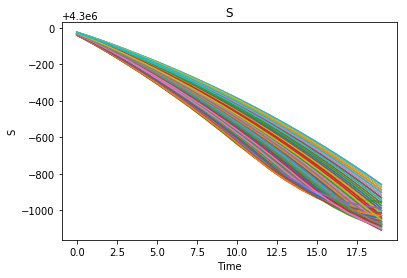

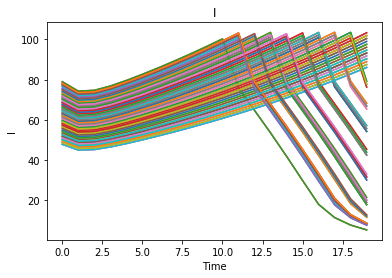

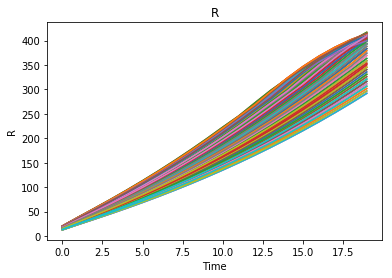

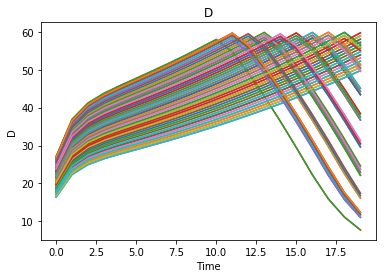

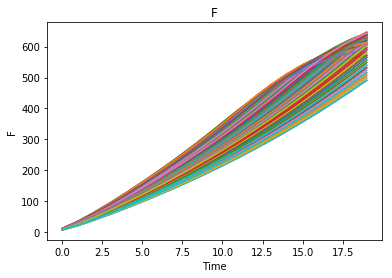

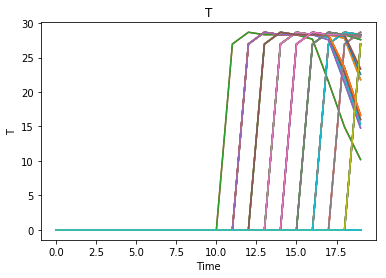

In [64]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100)
    
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines((experiments, outcomes), outcomes_to_show=outcome, 
                   density=False)
plt.show()